# Trading Gym Example: Training a PPO Agent with Real Crypto Data

This notebook demonstrates how to train a Proximal Policy Optimization (PPO) agent using the Trading Gym environment. We will leverage actual cryptocurrency data retrieved from Coingecko for a more realistic training scenario.

The primary steps of this example include:

1. **Data Retrieval**: We will obtain real-world cryptocurrency data from Coingecko to use for our trading environment.

2. **Data Splitting**: The dataset will be divided into three distinct parts:
   - Training Data: Used to train the PPO agent.
   - Validation Data: Employed to fine-tune and validate the agent's performance.
   - Test Data: Reserved for evaluating the agent's performance on unseen data, simulating real-world scenarios.

In [1]:
import os
import warnings

import gymnasium as gym
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnvWrapper
from stable_baselines3.common.evaluation import evaluate_policy

from gym_trading.envs.data_loader import PandasAssetChartDataLoader
from gym_trading.envs.exchange import BaseExchange
from gym_trading.envs.renderer import PyGamePlotRenderer
from gym_trading.envs.rewards import ProfitRewarder, OneStepProfitRewarder
from gym_trading.envs.action_space import BudgetAllocationSpace

from decimal import Decimal

from abc import ABC, abstractmethod

# Hide all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_top_ranked_cryptos(n):
    url = f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page={n}&page=1&sparkline=false"

    response = requests.get(url)
    data = response.json()

    top_cryptos = []
    for crypto in data:
        # print(crypto)
        top_cryptos.append(crypto['id'])

    return top_cryptos

In [3]:
def get_symbol_history(symbol, n_days):
    url = f'https://api.coingecko.com/api/v3/coins/{symbol}/market_chart'
    params = {
        'vs_currency': 'usd',
        'days': str(n_days),
    }
    response = requests.get(url, params=params)
    data = response.json()

    # Extract dates and prices from the API response
    timestamps = data['prices']
    dates = [pd.to_datetime(timestamp, unit='ms') for timestamp, _ in timestamps]
    prices = [price for _, price in timestamps]
    market_caps = [market_cap for _, market_cap in data['market_caps']]
    total_volumes = [total_volume for _, total_volume in data['total_volumes']]
    
    print(f'{symbol.upper()}: {len(dates) = }, {len(prices) = }, {len(market_caps) = }, {len(total_volumes) = }')

    return pd.DataFrame({
        'Date': dates,
        'Price': prices,
        'Market Cap': market_caps,
        'Total Volume': total_volumes
    })

In [4]:
N_DAYS = 365 * 3
SAVE_DIR = "crypto_datasets__days-" + str(N_DAYS)

In [5]:
def save_datasets(datasets, days):
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    for symbol, df in datasets.items():
        filename = f"{symbol}_{days}_days.csv"
        file_path = os.path.join(SAVE_DIR, filename)
        df.to_csv(file_path, index=False)
        print(f"Saved {symbol} dataset to {file_path}")
        
def load_datasets():
    datasets = {}
    try:
        for file in os.listdir(SAVE_DIR):
            if file.endswith(".csv"):
                symbol, days, _ = file.split("_")
                days = int(days)
                file_path = os.path.join(SAVE_DIR, file)
                df = pd.read_csv(file_path)
                datasets[symbol] = df
    except FileNotFoundError:
        return datasets
    return datasets

In [6]:
datasets = load_datasets()

data_train_size = None

if len(datasets.keys()) == 0:
    print('downloading new data')
    
    top_cryptos = get_top_ranked_cryptos(10)
    print('Downloading datasets for top cryptos: {top_cryptos}')
    
    df = pd.DataFrame()

    for symbol in top_cryptos:
        df = get_symbol_history(symbol, N_DAYS)
        
        if data_train_size is None:
            data_train_size = len(df)
            
        if len(df) == data_train_size:
            datasets[symbol] = df
        
    save_datasets(datasets, N_DAYS)

downloading new data
BITCOIN: len(dates) = 1096, len(prices) = 1096, len(market_caps) = 1096, len(total_volumes) = 1096
ETHEREUM: len(dates) = 1096, len(prices) = 1096, len(market_caps) = 1096, len(total_volumes) = 1096
TETHER: len(dates) = 1096, len(prices) = 1096, len(market_caps) = 1096, len(total_volumes) = 1096
BINANCECOIN: len(dates) = 1096, len(prices) = 1096, len(market_caps) = 1096, len(total_volumes) = 1096
RIPPLE: len(dates) = 1096, len(prices) = 1096, len(market_caps) = 1096, len(total_volumes) = 1096
USD-COIN: len(dates) = 1096, len(prices) = 1096, len(market_caps) = 1096, len(total_volumes) = 1096
STAKED-ETHER: len(dates) = 1012, len(prices) = 1012, len(market_caps) = 1012, len(total_volumes) = 1012
CARDANO: len(dates) = 1096, len(prices) = 1096, len(market_caps) = 1096, len(total_volumes) = 1096
DOGECOIN: len(dates) = 1096, len(prices) = 1096, len(market_caps) = 1096, len(total_volumes) = 1096
SOLANA: len(dates) = 1096, len(prices) = 1096, len(market_caps) = 1096, len(to

In [7]:
# Revoming stable coins:
keys_to_remove = []

for symbol, df in datasets.items():
    if abs(1 - df["Price"].mean()) < 0.1:
        print(f'Ignoring {symbol}')
        keys_to_remove.append(symbol)

# Now, remove the keys from the dictionary
for key in keys_to_remove:
    del datasets[key]

Ignoring tether
Ignoring usd-coin


In [8]:
# Aligning all the dataset to have same timestamps
first_df = next(iter(datasets.values()))
first_df['Date'] = pd.to_datetime(first_df['Date'])

common_date_range = pd.date_range(start=first_df['Date'].min(), end=first_df['Date'].max(), freq='D')

for symbol, df in datasets.items():
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.round('D')
    
    df = df.groupby('Date').first().reset_index()

    df = df[df['Date'].isin(common_date_range)]
    
    datasets[symbol] = df

In [9]:
df = list(datasets.values())[0]
df['Date'].iloc[1] - df['Date'].iloc[0]

Timedelta('1 days 00:00:00')

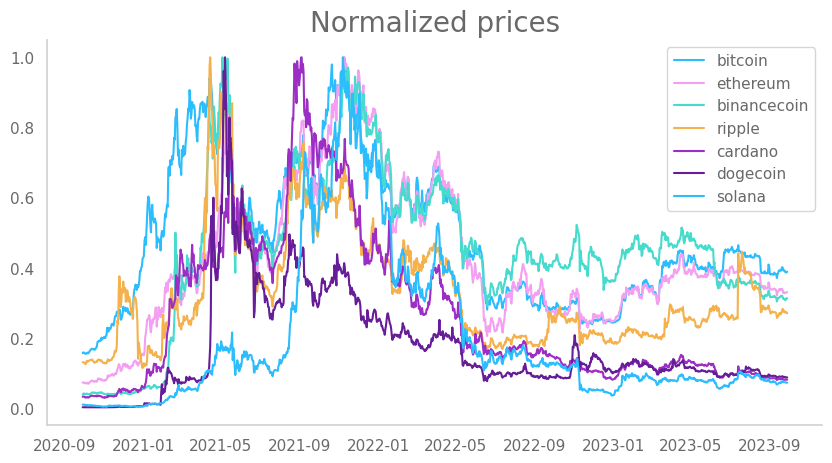

In [10]:
for symbol, df in datasets.items():
    plt.plot(df['Date'], df['Price'] / np.max(df['Price']), label=symbol)

plt.title('Normalized prices')
plt.legend()
plt.show()

In [11]:
SYMBOLS = list(datasets.keys())
SYMBOLS

['bitcoin',
 'ethereum',
 'binancecoin',
 'ripple',
 'cardano',
 'dogecoin',
 'solana']

In [12]:
def train_valid_test_df(df, split_rate=0.2):
    train_df, test_df = train_test_split(df, test_size=split_rate, shuffle=False)
    train_df, valid_df = train_test_split(train_df, test_size=split_rate, shuffle=False)
    
    print(f'{len(train_df) = }, {len(valid_df) = }, {len(test_df) = }')
    
    return train_df, valid_df, test_df

len(train_df) = 700, len(valid_df) = 176, len(test_df) = 219


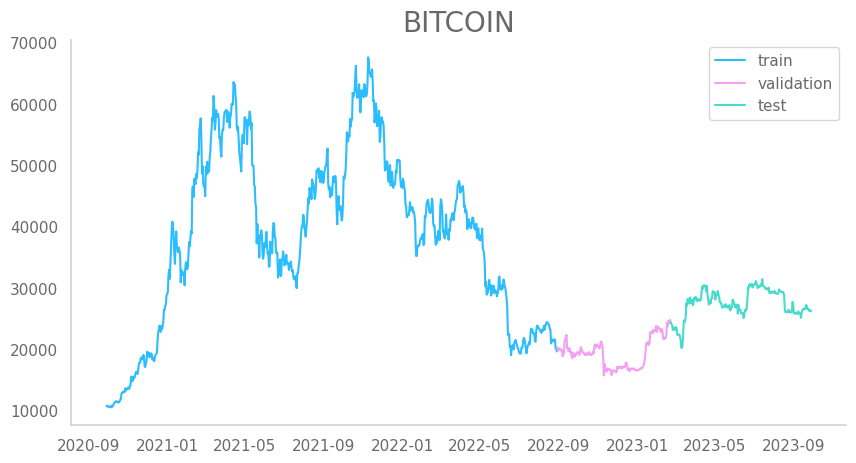

len(train_df) = 700, len(valid_df) = 176, len(test_df) = 219


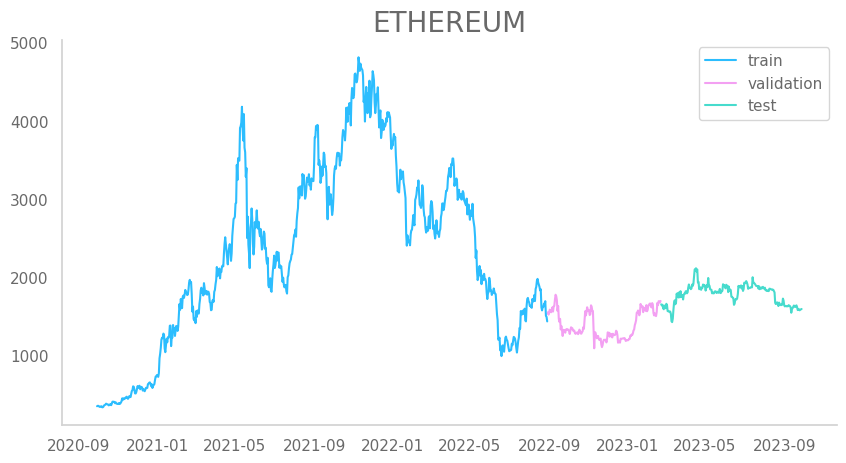

len(train_df) = 700, len(valid_df) = 176, len(test_df) = 219


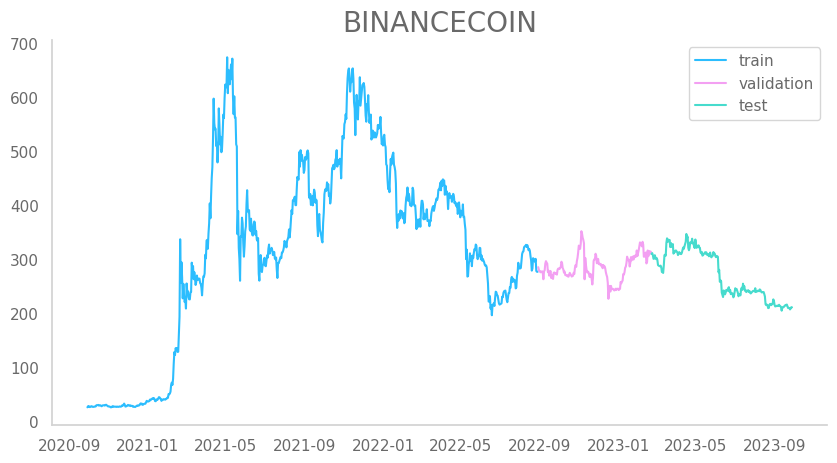

len(train_df) = 700, len(valid_df) = 176, len(test_df) = 219


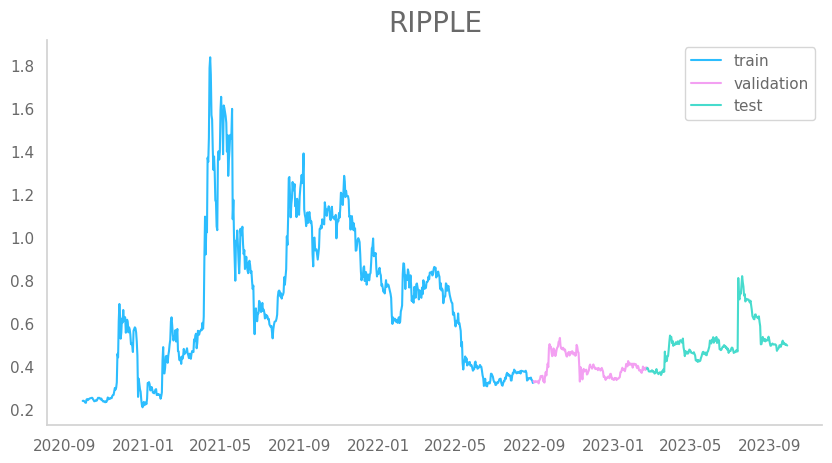

len(train_df) = 700, len(valid_df) = 176, len(test_df) = 219


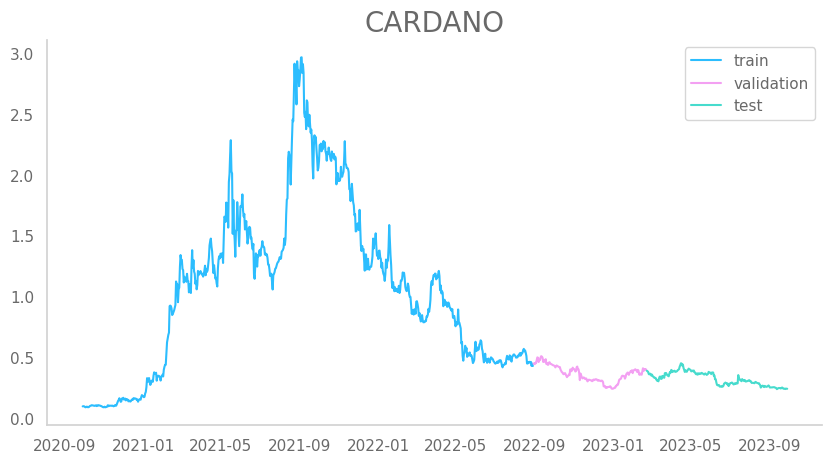

len(train_df) = 700, len(valid_df) = 176, len(test_df) = 219


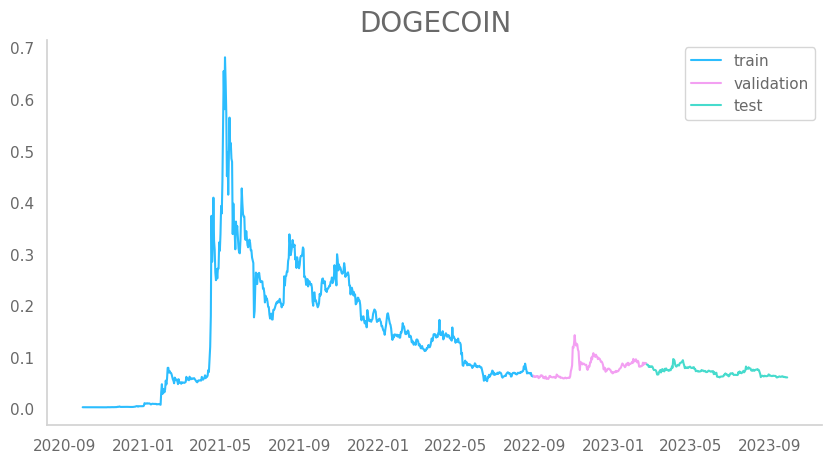

len(train_df) = 700, len(valid_df) = 176, len(test_df) = 219


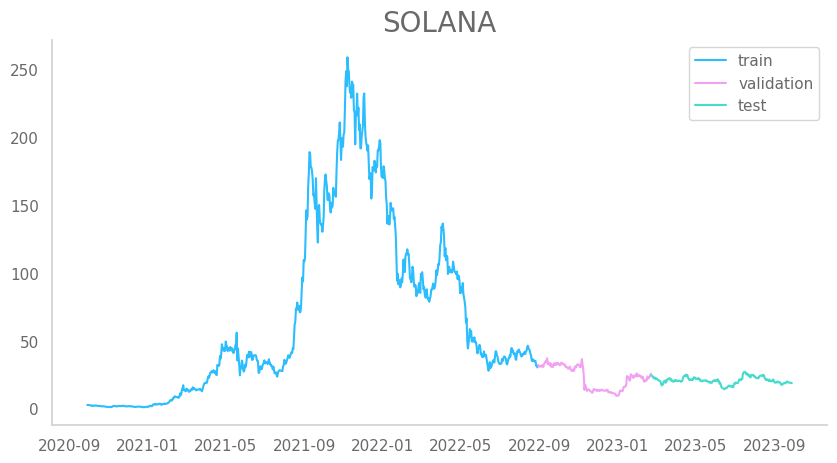

In [13]:
split_datasets = {}
for symbol, df in datasets.items():
    split_datasets[symbol] = train_valid_test_df(df)

    plt.plot(split_datasets[symbol][0]['Date'], split_datasets[symbol][0]['Price'], label=f'train')
    plt.plot(split_datasets[symbol][1]['Date'], split_datasets[symbol][1]['Price'], label=f'validation')
    plt.plot(split_datasets[symbol][2]['Date'], split_datasets[symbol][2]['Price'], label=f'test')

    plt.title(symbol.upper())
    plt.legend()
    plt.show()

Here, we will create three distinct environments, each with its associated dataset:

1. **Training Environment**: This environment will be paired with the training dataset. It is used to train the PPO agent to make informed decisions based on historical data.

2. **Validation Environment**: The validation environment will be associated with the validation dataset. It serves as a means to fine-tune the agent's parameters and assess its performance in a controlled environment.

3. **Test Environment**: The test environment will be linked to the test dataset. This environment is crucial for evaluating the agent's performance on unseen data, simulating real-world conditions.

By creating these three environments, we can systematically develop and evaluate our PPO agent for cryptocurrency trading without the need for extensive code commentary.

In [14]:
INIT_LIQUIDITY = Decimal('100.0')
BUY_FEE = Decimal('0.1')
SELL_FEE = Decimal('0.1')

# TRAIN ENV
train_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[0] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
train_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=train_data_loader,
    exchange=BaseExchange(train_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
)

# VALID ENV
valid_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[1] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
valid_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=valid_data_loader,
    exchange=BaseExchange(valid_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
)

# TEST ENV
test_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[2] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
test_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=test_data_loader,
    exchange=BaseExchange(test_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
    # renderer=PyGamePlotRenderer(render_fps=4),
    final_report_plot=True
)

In [15]:
observation = train_env.reset()[0]
observation

array([[1.06720283e+04, 1.97720211e+11, 1.98699643e+10, 3.54429596e+02,
        3.97948887e+10, 9.81846733e+09, 2.68494587e+01, 3.96469453e+09,
        4.09745120e+08, 2.41700873e-01, 1.09094502e+10, 1.47090560e+09,
        1.00103505e-01, 3.12073446e+09, 5.18815552e+08, 2.65268190e-03,
        3.35439040e+08, 1.08007304e+08, 2.95577526e+00, 1.15671368e+08,
        9.30954000e+06]], dtype=float32)

In [16]:
observation.shape

(1, 21)

Next, we'll proceed to create the PPO model using the Stable-Baselines3 library.

In [17]:
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, StackedObservations

train_vec_env = VecNormalize(SubprocVecEnv([lambda: train_env] * 10))
valid_vec_env = VecNormalize(DummyVecEnv([lambda: valid_env]))
test_vec_env = VecNormalize(DummyVecEnv([lambda: test_env]))

## Training the PPO Model with Stable-Baselines3

In this code section, we employ the Stable-Baselines3 library to create and train a Proximal Policy Optimization (PPO) model for cryptocurrency trading. The model is trained using historical data within a trading environment. Here's a breakdown of the key components:

- **RecurrentPPO**: We utilize the `RecurrentPPO` algorithm, which is an extension of PPO designed for environments with sequential data. This is particularly useful for time series data in cryptocurrency trading.

- **Logging and Time Steps**: We specify a log directory for storing training logs and set the total number of training time steps (`total_timesteps = 1e5`).

- **Model Initialization**: The PPO model is initialized with specific parameters, including the choice of policy (`MlpLstmPolicy`) and the training environment (`train_vec_env`).

- **Evaluation Callback**: We configure an evaluation callback (`EvalCallback`) to assess the model's performance during training. This callback periodically evaluates the model on a validation environment (`valid_vec_env`) and saves the best-performing model to a designated directory (`'./models'`).

- **Training**: The model is trained using the `model.learn` method, specifying the total number of training steps, the callback for evaluation, and a progress bar to track training progress.

This code section sets the stage for training our PPO model for cryptocurrency trading, and the subsequent cells will showcase the training and evaluation results.


In [18]:
from sb3_contrib import RecurrentPPO

log_dir = './logs/'
total_timesteps = 1e5

model = RecurrentPPO(
    policy="MlpLstmPolicy",
    env=train_vec_env,
    verbose=0,
    tensorboard_log=log_dir,
)

eval_callback = EvalCallback(
    eval_env=valid_vec_env,
    best_model_save_path='./models',
    log_path=log_dir,
    eval_freq=1000,
    n_eval_episodes=1,
    deterministic=True,
    render=False
)

callbacks = [eval_callback]

model.learn(
    total_timesteps=int(total_timesteps),
    callback=callbacks,
    progress_bar=True
)

Output()

Eval num_timesteps=10000, episode_reward=0.34 +/- 0.00

Episode length: 176.00 +/- 0.00

New best mean reward!

Eval num_timesteps=20000, episode_reward=0.10 +/- 0.00

Episode length: 176.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=0.28 +/- 0.00

Episode length: 176.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=0.30 +/- 0.00

Episode length: 176.00 +/- 0.00

Eval num_timesteps=50000, episode_reward=0.57 +/- 0.00

Episode length: 176.00 +/- 0.00

New best mean reward!

Eval num_timesteps=60000, episode_reward=0.70 +/- 0.00

Episode length: 176.00 +/- 0.00

New best mean reward!

Eval num_timesteps=70000, episode_reward=0.54 +/- 0.00

Episode length: 176.00 +/- 0.00

Eval num_timesteps=80000, episode_reward=0.76 +/- 0.00

Episode length: 176.00 +/- 0.00

New best mean reward!

Eval num_timesteps=90000, episode_reward=-0.19 +/- 0.00

Episode length: 176.00 +/- 0.00

Eval num_timesteps=100000, episode_reward=-0.07 +/- 0.00

Episode length: 176.00 +/- 0.00

In [19]:
%load_ext tensorboard
%tensorboard --logdir ./logs/

## Evaluating the Best PPO Model

In this code section, we evaluate the performance of the best-trained Proximal Policy Optimization (PPO) model for cryptocurrency trading. Here's an overview of what this code does:

- **Loading the Best Model**: We load the best-performing PPO model from the saved model checkpoint file (`'./models/best_model.zip'`). This model represents the culmination of our training efforts.

- **Evaluation**: We use the `evaluate_policy` function to assess the model's performance. This function calculates the mean reward and its standard deviation over a specified number of evaluation episodes (`n_eval_episodes=1`) using the test environment (`test_vec_env`). The evaluation is done in a deterministic manner (`deterministic=True`), ensuring consistent results.

- **Closing the Environment**: After evaluation, we close the test environment to release any resources it may be using.

- **Displaying Results**: Finally, we print the mean reward along with its standard deviation, providing a quantitative measure of how well the PPO model performs in the cryptocurrency trading task.

This code section allows us to gauge the effectiveness of our trained model in making trading decisions based on unseen data.

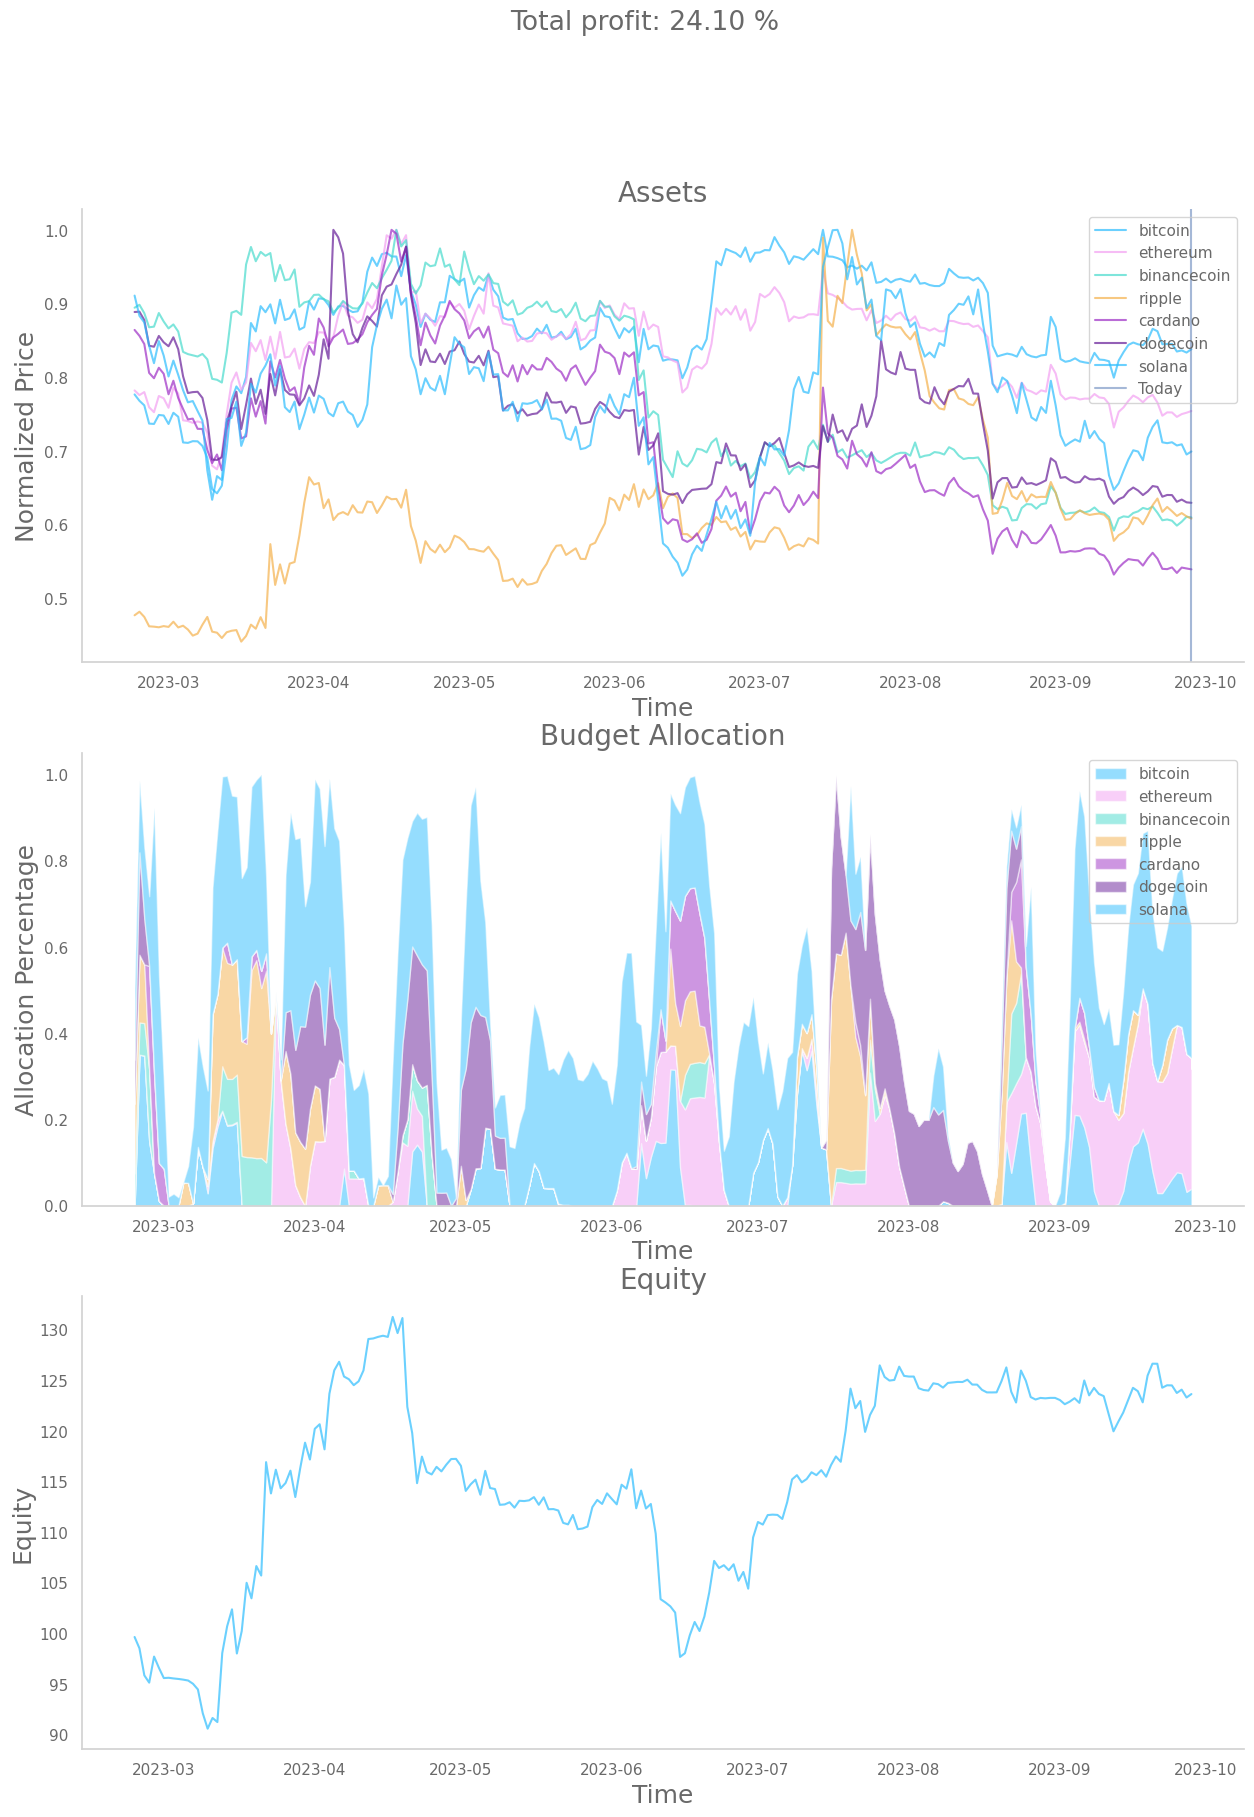

Mean reward: 1.52 +/- 0.00


In [20]:
best_model = RecurrentPPO.load('./models/best_model.zip')

mean_reward, std_reward = evaluate_policy(
    model,
    test_vec_env,
    n_eval_episodes=1,
    deterministic=True,
)

test_vec_env.close()

print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")